In [1]:
%load_ext autoreload
%autoreload 2
# from method_optimized import IV
from method import IV
from simulator import Simulator
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import pandas as pd
import numpy as np
import quantities as pq
import seaborn as sns
from exana.statistics import plot_xcorr
from tools import savefig, fix_figure, corrcoef, despine, set_style
import copy
from IPython.display import display
%matplotlib inline

# Slow synapse parameters

In [2]:
# from params_AI import parameters
# sim = Simulator(parameters, fname='network-power', 
#                 stim_N=5000)
# sim.simulate(save=True, raster=False)
# dataa = sim.data
dataa = np.load('results/params_3.npz')['data'][()]

# from params_SI import parameters
# sim = Simulator(parameters, fname='test_SI', data_path='results', 
#                 stim_N=100, stim_period=30, stim_dist='poisson', stim_amp_ex=10.0)
# sim.simulate(state=True, save=True, raster=True)

# dataa = sim.data

# dataa = np.load('results/params_SI.npz')['data'][()]

In [3]:
dataa['params']

{'C_ex': 100,
 'C_in': 25,
 'C_m': 1.0,
 'E_L': 0.0,
 'J': 0.2,
 'J_ex': 0.0896232149990653,
 'J_high': 2.05,
 'J_high_ex': 0.9186379537404191,
 'J_high_in': 0.9186379537404191,
 'J_in': 0.2688696449971959,
 'J_low': 0.05,
 'J_low_ex': 0.022405803749766324,
 'J_low_in': 0.022405803749766324,
 'NA': 0.37,
 'N_ex': 1000,
 'N_in': 250,
 'N_neurons': 1250,
 'N_rec_spike_ex': None,
 'N_rec_spike_in': None,
 'N_rec_state_ex': None,
 'N_rec_state_in': None,
 'S': 10.3,
 'V_m': 0.0,
 'V_reset': 0.0,
 'V_th': 20.0,
 'data_path': 'results',
 'delay': 1.5,
 'density': 100000.0,
 'eps': 0.1,
 'eta': 0.9,
 'fname': 'params_3',
 'g': 3.0,
 'msd': 4321,
 'n': 1.36,
 'num_threads': 4,
 'p_var': 0.5,
 'r': 0.1,
 'rate_ex': 13.103176750796564,
 'rate_in': 11.754008826610173,
 'rate_p': 3694.2604330557783,
 'res': 0.1,
 'status': {'time': 3691791.0},
 'stim_N': 30000,
 'stim_N_ex': 800,
 'stim_N_in': 0,
 'stim_amp_ex': 10.0,
 'stim_amp_in': 0.0,
 'stim_dist': 'poisson',
 'stim_duration': 2.0,
 'stim_max_

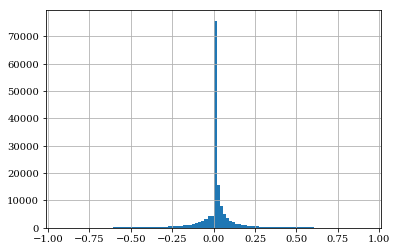

In [4]:
conn = dataa['connections']
conn.weight.hist(bins=100)

In [5]:
spiketrains = {s['sender']: {'pop': pop, 'times': s['times']}
               for pop in ['in', 'ex']
               for s in dataa['spiketrains'][pop]}

In [6]:
# B = 1
# # Find A and D
# affectors = conn.loc[(conn.target==B) & (conn.weight > 0)]
# m1 = affectors.weight.max()
# D = affectors[affectors.weight==m1].source
# D = int(D)
# m2 = conn.loc[(conn.source==D) & (conn.weight!=m1)].weight.max()
# A_ = conn.loc[(conn.source==D) & (conn.weight==m2)].target
# A_ = int(A_)
# print(A_, D)

In [37]:
# source, target = 98, 851 # BAD
source, target = 91, 898 # GOOD

In [38]:
period = np.min(np.diff(dataa['epoch']['times']))
binsize = 1
bins = np.arange(0, period + binsize, binsize)
winsize = 4
latency = 3
N = 30000
names = ['source', 'target']

In [39]:
weight = conn.loc[(conn.source==source) & (conn.target==target)].weight.sum()
print('target is targeted by source, w = {:.4f}'.format(weight))

target is targeted by source, w = 0.6969


In [40]:
t_stop = dataa['params']['status']['time']

In [41]:
cc = corrcoef([spiketrains[source]['times'], 
          spiketrains[target]['times']], t_stop=t_stop, binsize=4)
pd.DataFrame(cc, index=names, columns=names)

,source,target
source,1.000000,0.132842
target,0.132842,1.000000


In [42]:
iv = IV(spiketrains[source]['times'], 
         spiketrains[target]['times'],
         dataa['epoch']['times'],
         winsize, latency)

In [43]:
iv.prob

{'pcausal': 7.177591854201637e-13,
 'pfast': 1.5543122344752192e-13,
 'ppeak': 1.0,
 'ptime': 6.0}

In [44]:
iv.trans_prob

0.22342381922500057

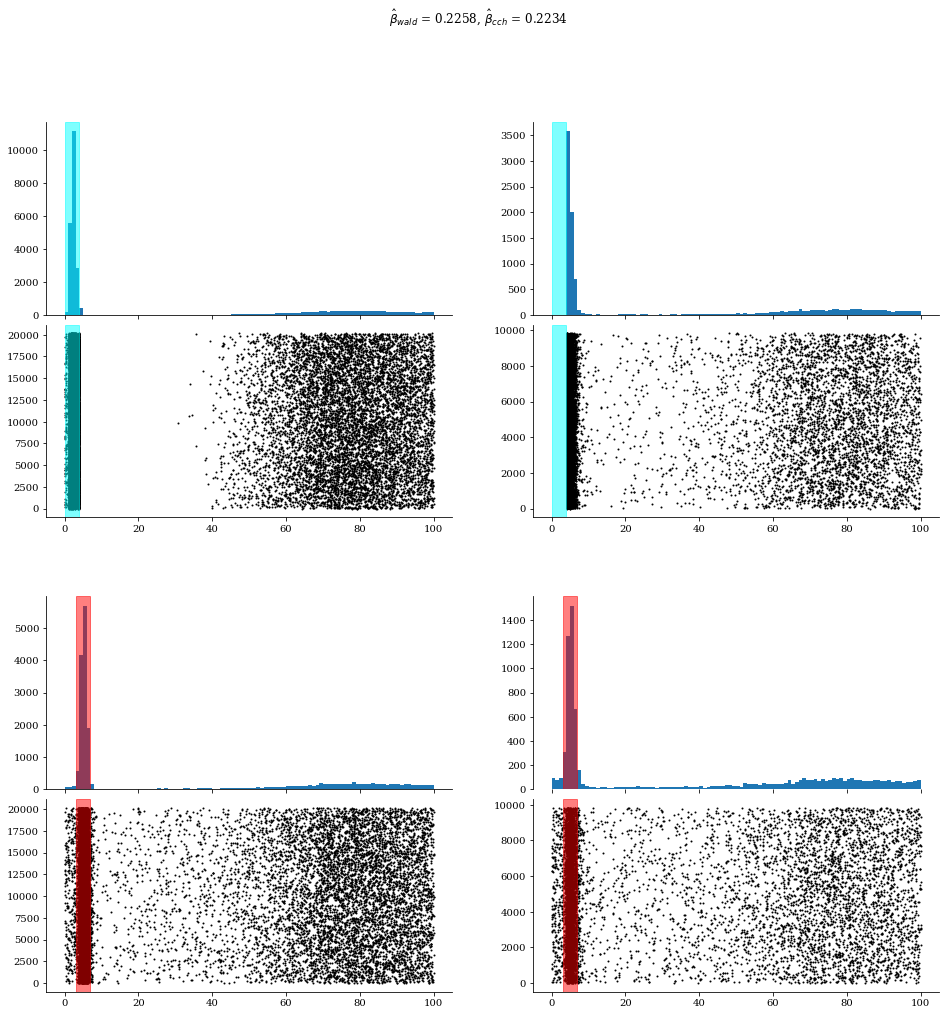

In [45]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(16,16))
gs = GridSpec(2, 2)
for i, idxs in enumerate([iv.Stim, iv.StimRef]):
    iv.plot('source', idxs, gs=gs[0, i])
    iv.plot('target', idxs, gs=gs[1, i])
plt.suptitle('$\\hat\\beta_{{wald}}$ = {:.4f}, $\\hat\\beta_{{cch}}$ = {:.4f}'.format(iv.wald, iv.trans_prob));

In [46]:
period = np.min(np.diff(iv.stim_times))
bins = np.arange(0, period + 1, iv.winsize)
for name in ['StimRef', 'Stim']:
    trials = np.array(iv.trials('target'))[getattr(iv, name)]
    times = [t for i in trials for t in i]
    count, bins = np.histogram(times, bins)
    print(name, count[1] / count[0])

StimRef 6.385159010600707
Stim 14.53968253968254


In [15]:
ybs = ivb.lams[ivb.Stim, 1]
ybsr = ivb.lams[ivb.StimRef, 1]

ybns = ivb.lams[ivb.Stim, 3]
ybnsr = ivb.lams[ivb.StimRef, 3]

print(ybs.mean(), ybsr.mean(), ybs.sum(), ybsr.sum(), len(ybs), len(ybsr))
print(ybns.mean(), ybnsr.mean(), ybns.sum(), ybnsr.sum(), len(ybns), len(ybnsr))

0.8781460441668861 0.7209710441649605 23342.0 2465.0 26581 3419
0.01576313908430834 0.01608657502193624 419.0 55.0 26581 3419


In [44]:
iva = IV(spiketrains[A]['times'], 
         spiketrains[C]['times'],
         dataa['epoch']['times'][:N],
         winsize, latency)

In [51]:
iva.cch()

0.8665393338904143 0.8465804066543439


(0.019958927236070425,
 array([ 2.93508668e-12, -4.44089210e-15,  2.59792188e-13, -1.70086167e-13,
        -4.21884749e-15]),
 5.0)

In [33]:
len(iva.stim_times[iva.StimRef])

1623

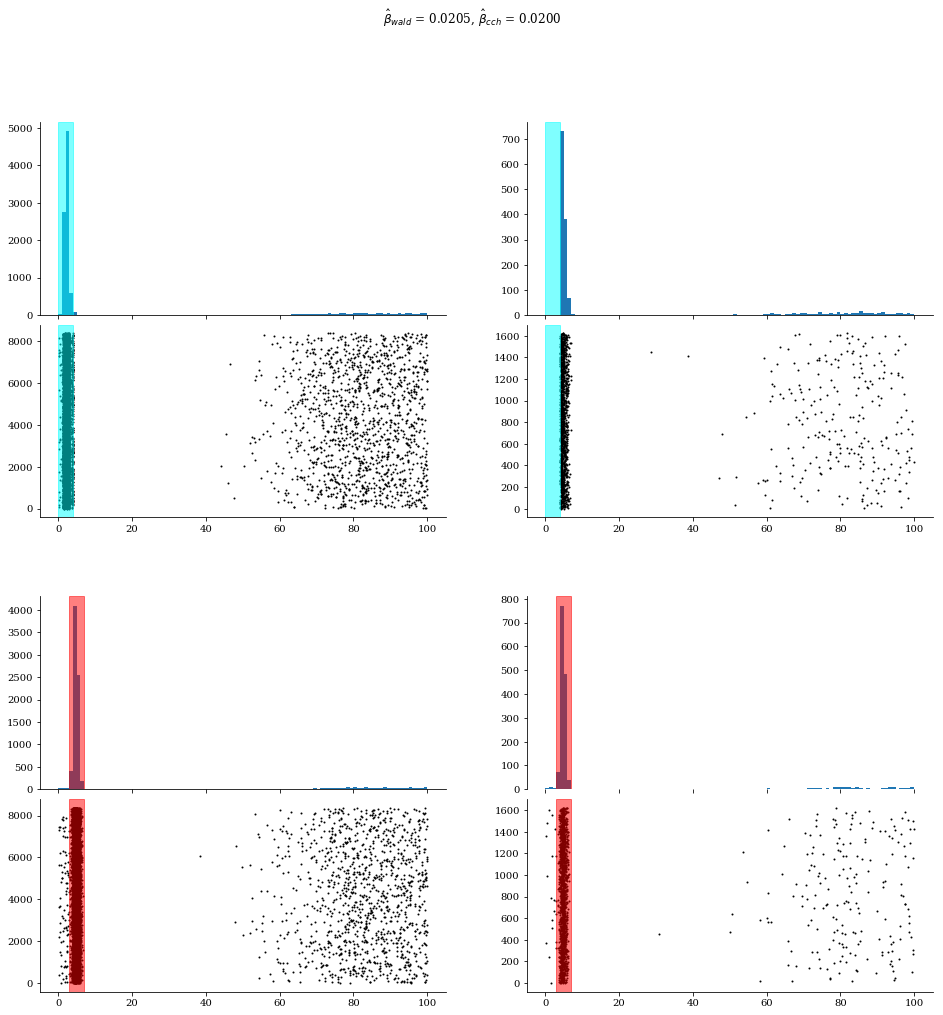

In [35]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(16,16))
gs = GridSpec(2, 2)
for i, idxs in enumerate([iva.Stim, iva.StimRef]):
    iva.plot('source', idxs, gs=gs[0, i])
    iva.plot('target', idxs, gs=gs[1, i])
plt.suptitle('$\\hat\\beta_{{wald}}$ = {:.4f}, $\\hat\\beta_{{cch}}$ = {:.4f}'.format(iva.wald, iva.cch()[0]));

In [32]:
yas = iva.lams[iva.Stim, 1]
yasr = iva.lams[iva.StimRef, 1]

yans = iva.lams[iva.Stim, 3]
yansr = iva.lams[iva.StimRef, 3]

In [33]:
print(yas.mean(), yasr.mean(), yas.sum(), yasr.sum(), len(yas), len(yasr))
print(yans.mean(), yansr.mean(), yans.sum(), yansr.sum(), len(yans), len(yansr))

0.6797024442082891 0.7067796610169491 6396.0 417.0 9410 590
0.01487778958554729 0.013559322033898305 140.0 8.0 9410 590


In [16]:
def model(x):
    return 1/(1+np.exp(-x))

In [17]:
%%time
res = []
res_ns = []
regress = []
regress_ns = []
N_trials = [1000,2500,5000,7500,10000,12500,15000,17500,20000,25000,30000]
for N in N_trials:
    ws = [[], []]
    ws_ns = [[], []]
    regs = [[], []]
    regs_ns = [[], []]
    for i, AB in enumerate([A, B]):
        iv = IV(spiketrains[AB]['times'], spiketrains[C]['times'],
                 dataa['epoch']['times'][:N],
                 winsize, latency)
        ws[i].append(iv.wald)
        ws_ns[i].append(iv.wald_ns)
        logit = model(float(iv.logreg.coef_) + float(iv.logreg.intercept_))
        logit_ns = model(float(iv.logreg_ns.coef_) + float(iv.logreg_ns.intercept_))
        regs[i].append(logit)
        regs_ns[i].append(logit_ns)
    res.append(ws)
    res_ns.append(ws_ns)
    regress.append(regs)
    regress_ns.append(regs_ns)
res, res_ns, regress, regress_ns = np.array(res), np.array(res_ns), np.array(regress), np.array(regress_ns)

CPU times: user 6.84 s, sys: 0 ns, total: 6.84 s
Wall time: 6.84 s


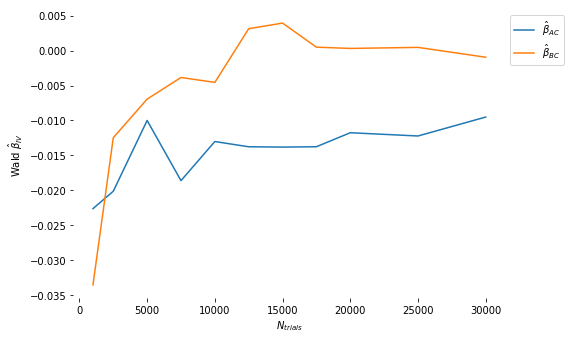

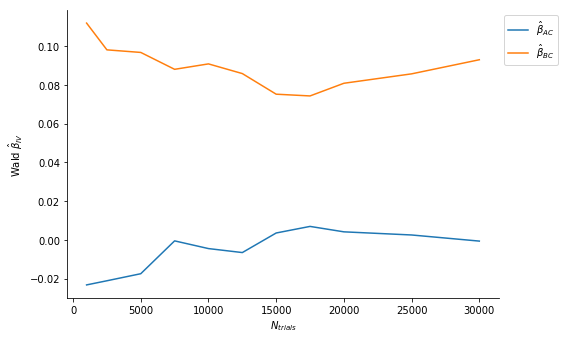

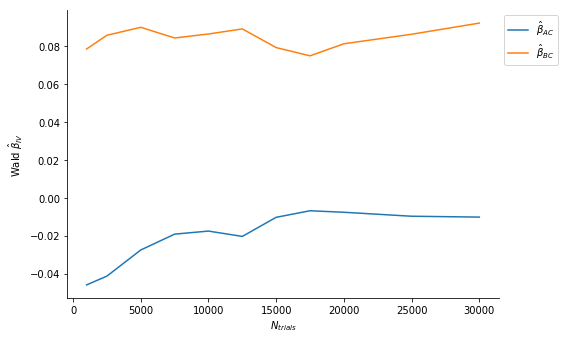

In [18]:
plt.figure()
plt.plot(N_trials, res[:,0], label='$\\hat\\beta_{AC}$')
plt.plot(N_trials, res[:,1], label='$\\hat\\beta_{BC}$')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('$N_{trials}$')
plt.ylabel('Wald $\\hat\\beta_{IV}$')
sns.despine(bottom=True, left=True)
fix_figure()
savefig(plt.gcf(), 'wald_network')

plt.figure()
plt.plot(N_trials, res_ns[:,0], label='$\\hat\\beta_{AC}$')
plt.plot(N_trials, res_ns[:,1], label='$\\hat\\beta_{BC}$')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('$N_{trials}$')
plt.ylabel('Wald $\\hat\\beta_{IV}$')
sns.despine()
fix_figure()
savefig(plt.gcf(), 'wald_network_ns')

plt.figure()
plt.plot(N_trials, res[:,0] + res_ns[:,0], label='$\\hat\\beta_{AC}$')
plt.plot(N_trials, res[:,1] + res_ns[:,1], label='$\\hat\\beta_{BC}$')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('$N_{trials}$')
plt.ylabel('Wald $\\hat\\beta_{IV}$')
sns.despine()
fix_figure()
savefig(plt.gcf(), 'wald_network_corrected')

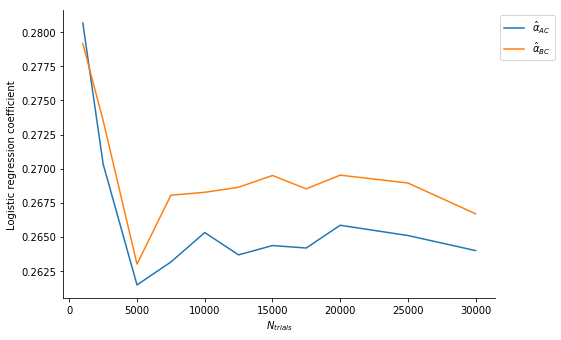

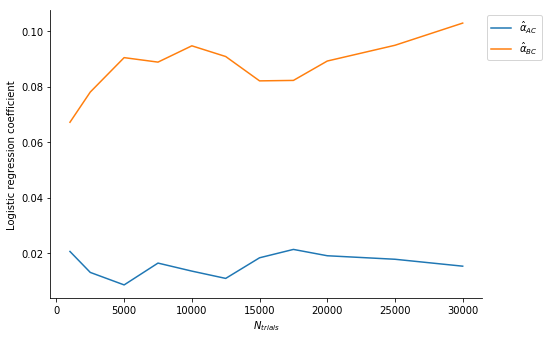

In [19]:
plt.figure()
plt.plot(N_trials, regress[:,0], label='$\\hat\\alpha_{AC}$')
plt.plot(N_trials, regress[:,1], label='$\\hat\\alpha_{BC}$')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('$N_{trials}$')
plt.ylabel('Logistic regression coefficient')
sns.despine()
fix_figure()

plt.figure()
plt.plot(N_trials, regress_ns[:,0], label='$\\hat\\alpha_{AC}$')
plt.plot(N_trials, regress_ns[:,1], label='$\\hat\\alpha_{BC}$')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('$N_{trials}$')
plt.ylabel('Logistic regression coefficient')
sns.despine()
fix_figure()

In [20]:
set_style('notebook')
t_stop = dataa['params']['status']['time']
spiketrains_ABC = [spiketrains[idx]['times'] for idx in [A, B, C]]
names = ['A', 'B', 'C']
colors = sns.color_palette()

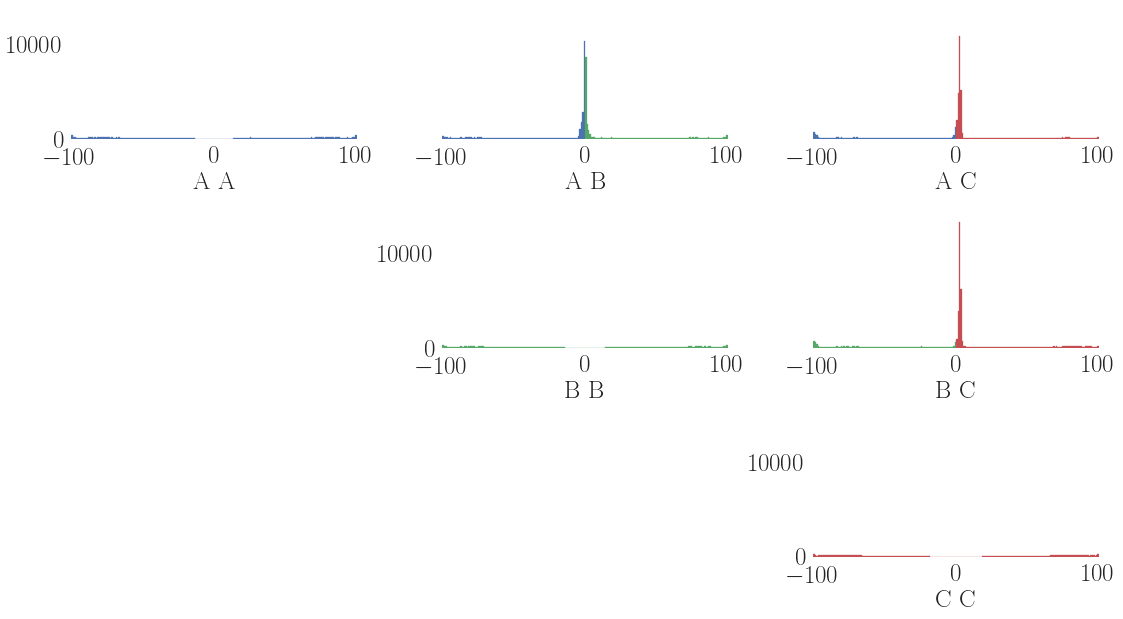

In [21]:
plot_xcorr(spiketrains_ABC, colors=colors, time_limit=100, binsize=1,
           xticksvisible=True, yticksvisible=False, density=False,
           names=names);
sns.despine(bottom=True, left=True)
fig = plt.gcf()
savefig(fig, 'xcorr_network')

In [22]:
from exana.statistics.tools import ccg_significance

time_limit = 30
binsize = 1
ylim = [0, 10000]


13251
10831


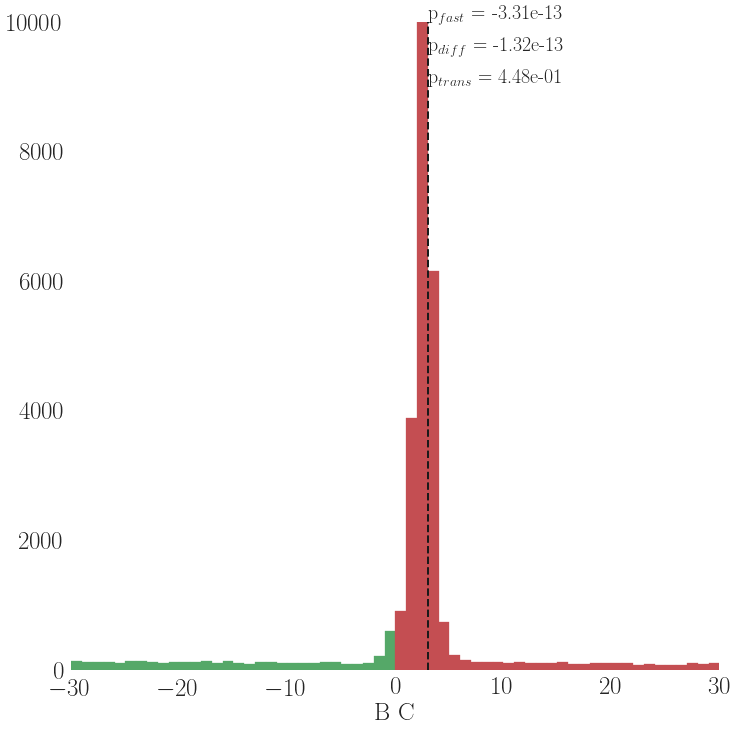

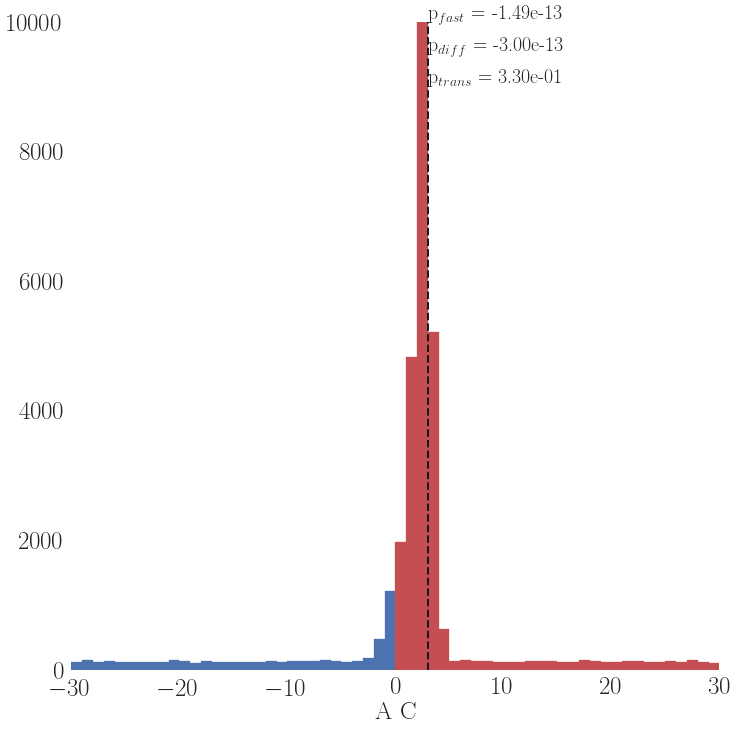

In [23]:
for idx, sl in enumerate([slice(1,3), slice(0,3,2)]):
    pcausal, pfast, bins, cch, cch_s = ccg_significance(*spiketrains_ABC[sl], binsize, time_limit, 
                                            hollow_fraction=.6, width=10)
    
    _, _ = plot_xcorr(spiketrains_ABC[sl], colors=colors[sl], time_limit=time_limit, 
                            binsize=binsize, acorr=False, ylim=ylim, density=False,
                            names=names[sl]);
    ax = plt.gca()
    mask = (bins >= latency) & (bins <= latency + winsize)
    m = np.max(cch[mask])
    print(m)
    pmin = pcausal[cch == m]
    trans_prob = sum(cch[mask] - cch_s[mask]) / len(spiketrains_ABC[sl][0])
    plt.plot([bins[pcausal==pmin][0], bins[pcausal==pmin][0]], 
             [0, m], ls='--', c='k')
    plt.annotate('p$_{{fast}}$ = {:.2e}'.format(pfast[cch == m][0]), 
                 [bins[pcausal == pmin][0], ylim[1]])
    plt.annotate('p$_{{diff}}$ = {:.2e}'.format(pcausal[cch == m][0]), 
                 [bins[pcausal == pmin][0], ylim[1] - ylim[1]*.05])
    plt.annotate('p$_{{trans}}$ = {:.2e}'.format(trans_prob), 
                 [bins[pcausal == pmin][0], ylim[1] - ylim[1]*.1])
    ax.set_aspect(time_limit * 2 / ylim[1])
    ax.set_position([0, 0, 1, 1])
    sns.despine(bottom=True, left=True)